linear regression model (train, Make Predictions, evaluate and Visualize Results)

Tải dữ liệu thành công!

Bắt đầu huấn luyện mô hình Linear Regression...
Huấn luyện hoàn tất!

--- Đánh giá hiệu suất mô hình ---
Kết quả trên tập Training:
  Mean Absolute Error (MAE):   1.9997
  Mean Squared Error (MSE):    6.0971
  Root Mean Squared Error (RMSE): 2.4692
  R-squared (R²):              0.7723

Kết quả trên tập Development:
  Mean Absolute Error (MAE):   1.9911
  Mean Squared Error (MSE):    6.4840
  Root Mean Squared Error (RMSE): 2.5464
  R-squared (R²):              0.7505

Kết quả trên tập Test:
  Mean Absolute Error (MAE):   1.7515
  Mean Squared Error (MSE):    4.7132
  Root Mean Squared Error (RMSE): 2.1710
  R-squared (R²):              0.7832

Đang tạo biểu đồ trực quan hóa kết quả...
Đã lưu biểu đồ 'actual_vs_predicted_scatter.png'
Đã lưu biểu đồ 'prediction_over_time.png'


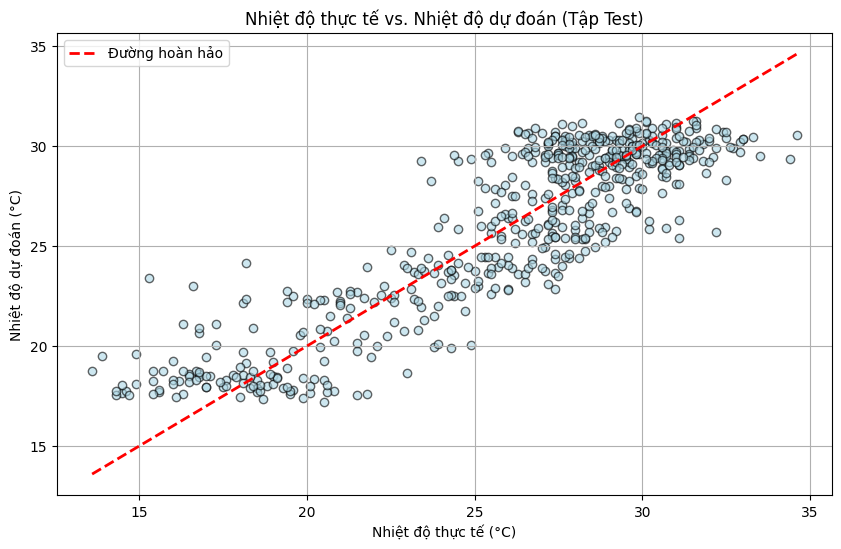

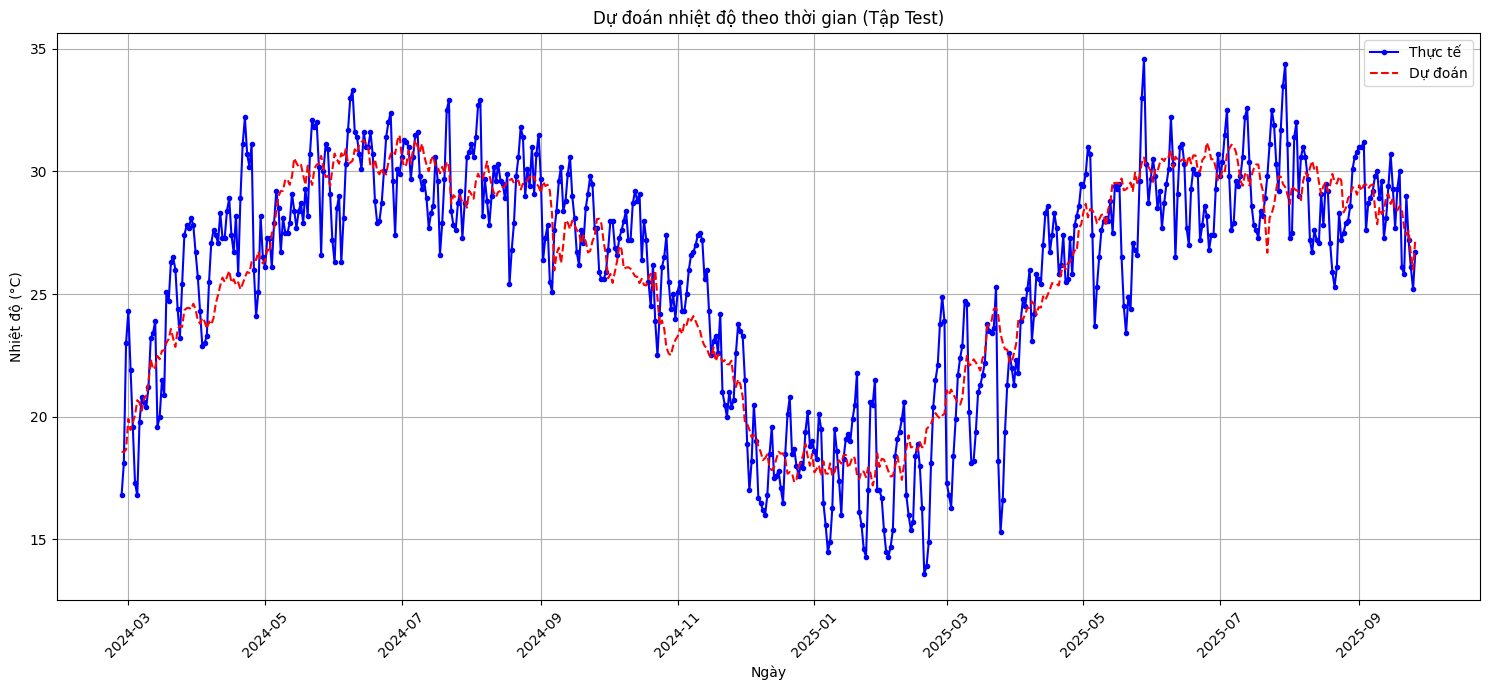

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

def train_and_evaluate():
    """
    Loads data, trains a Linear Regression model, evaluates it,
    and visualizes the results.
    """
    # --- 1. Load Datasets ---
    try:
        X_train = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_train_transformed.csv', index_col='datetime', parse_dates=True)
        y_train = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_train.csv', index_col='datetime', parse_dates=True)

        X_dev = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_dev_transformed.csv', index_col='datetime', parse_dates=True)
        y_dev = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_dev.csv', index_col='datetime', parse_dates=True)

        X_test = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/X_test_transformed.csv', index_col='datetime', parse_dates=True)
        y_test = pd.read_csv('C:/Users/lenovo/Downloads/python exercises/ml final 2/hanoi-weather-forecast/processed_data/y_test.csv', index_col='datetime', parse_dates=True)
        
        print("Tải dữ liệu thành công!")
    except FileNotFoundError as e:
        print(f"Lỗi: Không tìm thấy tệp. Vui lòng kiểm tra lại đường dẫn.")
        print(e)
        return

    # --- 2. Initialize and Train the Model ---
    print("\nBắt đầu huấn luyện mô hình Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    print("Huấn luyện hoàn tất!")

    # --- 3. Make Predictions ---
    y_train_pred = lr_model.predict(X_train)
    y_dev_pred = lr_model.predict(X_dev)
    y_test_pred = lr_model.predict(X_test)

    # --- 4. Evaluate the Model ---
    print("\n--- Đánh giá hiệu suất mô hình ---")

    def evaluate_model(y_true, y_pred, set_name):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        print(f"Kết quả trên tập {set_name}:")
        print(f"  Mean Absolute Error (MAE):   {mae:.4f}")
        print(f"  Mean Squared Error (MSE):    {mse:.4f}")
        print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
        print(f"  R-squared (R²):              {r2:.4f}\n")

    evaluate_model(y_train, y_train_pred, "Training")
    evaluate_model(y_dev, y_dev_pred, "Development")
    evaluate_model(y_test, y_test_pred, "Test")

    # --- 5. Visualize Results (Test set) ---
    print("Đang tạo biểu đồ trực quan hóa kết quả...")

    # Scatter Plot: Actual vs. Predicted Values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', c='lightblue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Đường hoàn hảo')
    plt.title('Nhiệt độ thực tế vs. Nhiệt độ dự đoán (Tập Test)')
    plt.xlabel('Nhiệt độ thực tế (°C)')
    plt.ylabel('Nhiệt độ dự đoán (°C)')
    plt.grid(True)
    plt.legend()
    print("Đã lưu biểu đồ 'actual_vs_predicted_scatter.png'")

    # Line Chart: Comparison over time
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test['target_temp_5d'], label='Thực tế', color='blue', marker='.')
    plt.plot(y_test.index, y_test_pred, label='Dự đoán', color='red', linestyle='--')
    plt.title('Dự đoán nhiệt độ theo thời gian (Tập Test)')
    plt.xlabel('Ngày')
    plt.ylabel('Nhiệt độ (°C)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    print("Đã lưu biểu đồ 'prediction_over_time.png'")

if __name__ == '__main__':
    train_and_evaluate()